In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from PIL import Image
from scipy import ndimage, stats

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset, TensorDataset
import torchvision.transforms as T
from tqdm import tqdm

# Set the device
if th.cuda.is_available():
    device = th.device("cuda")
    print(f"Using device {device}: {th.cuda.get_device_name()}")
elif th.backends.mps.is_available():
    device = th.device("mps")
    print(f"Using device {device}")
else:
    device = th.device("cpu")
    print(f"Using device {device}")

Using device cuda: Tesla T4
Using device cuda: Tesla T4


In [3]:
# Manually override to cpu
# device = th.device("cpu")

In [4]:
!git clone https://github.com/HansDahleKvadsheim/Sea-Pix-GAN-Group-6.git

Cloning into 'Sea-Pix-GAN-Group-6'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 159 (delta 11), reused 10 (delta 3), pack-reused 133 (from 1)
Receiving objects: 100% (159/159), 252.86 MiB | 35.12 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Hyperparamters

In [6]:
hyperparams = {
    "learning_rate": 2e-4,
    "batch_size": 64,
    "epochs": 150,
    "l1_lambda": 100,
    "adam_betas": (0.5, 0.999), # default values are (0.9, 0.999)
    "data_splits": [4/6, 1/6, 1/6],
    "test_run": False, # Set to True to run a test with a smaller dataset
    "test_run_size": 192,
}

# Create the path and model data directory itself
model_data = "./rsc/first_model"
if not os.path.exists(model_data):
    os.makedirs(model_data)

# Dataset

## Preparing the dataset

In [24]:
class PairedImageDataset(Dataset):
    def __init__(self, input_data_dir: str, gt_data_dir: str, size=None, excluded=None, random_perturbations=True):
        # Define the data directories and the list of image names (same for input and gt)
        self.input_data_dir = input_data_dir
        self.gt_data_dir = gt_data_dir

        # --- MODIFICATION START ---
        # Filter file list to only include valid image files
        all_files_in_dir = os.listdir(input_data_dir)
        image_extensions = ('.png', '.jpg', '.jpeg', '.bmp')

        self.image_files = [
            f for f in all_files_in_dir
            if os.path.isfile(os.path.join(input_data_dir, f)) and f.lower().endswith(image_extensions)
        ]
        # --- MODIFICATION END ---

        # Select the correct amount of images if a size is provided (for smaller experiments)
        if size is not None:
            self.image_files = self.image_files[:size]

        # Filter out any image names if provided (to keep figure images out of training)
        if excluded is not None:
            self.image_files = [filename for filename in self.image_files if filename not in excluded]

        # Define the image transforms (using the fix from our previous conversation)
        # Resize to a larger size (e.g., 286)
        self.resize_transform = T.Resize([286, 286], interpolation=T.InterpolationMode.NEAREST)

        # 'self.transform' now only contains RANDOM augmentations + normalization
        self.transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomCrop(256),  # Crop down to 256
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]) if random_perturbations else T.Compose([
            T.CenterCrop(256), # For non-random, just center crop
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __len__(self):
        # Return the number of image pairs in the dataset
        return len(self.image_files)

    def __getitem__(self, i):
        # Get the image paths for both the input and the gt
        input_image_path = os.path.join(self.input_data_dir, self.image_files[i])
        gt_image_path = os.path.join(self.gt_data_dir, self.image_files[i])

        # Read in the input image and correct the color and channel order (cv2 reads in BGR)
        input_image = cv2.imread(input_image_path)
        # Check if image loading failed (in case of a new error)
        if input_image is None:
            raise IOError(f"Could not read input image: {input_image_path}")
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

        # Read in the gt image and correct the color and channel order (cv2 reads in BGR)
        gt_image = cv2.imread(gt_image_path)
        if gt_image is None:
            raise IOError(f"Could not read ground truth image: {gt_image_path}")
        gt_image = cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB)

        # Convert numpy arrays to torch tensors via PIL images
        input_image = T.ToTensor()(Image.fromarray(input_image))
        gt_image = T.ToTensor()(Image.fromarray(gt_image))

        # Apply the deterministic resize to EACH image INDIVIDUALLY
        input_image = self.resize_transform(input_image)
        gt_image = self.resize_transform(gt_image)

        # Stack images along the batch dimension
        stacked_images = th.stack([input_image, gt_image])

        # Apply the RANDOM transforms to the stack
        transformed_images = self.transform(stacked_images)

        # Return the transformed images ([input_image, gt_image])
        return transformed_images[0], transformed_images[1]

## Running dataset construction code

In [25]:
# Get the dataset paths
figure_input_data_dir = "/content/drive/MyDrive/LSUI/figure_images/input"
figure_gt_data_dir = "/content/drive/MyDrive/LSUI/figure_images/ground_truth"
input_data_dir = "/content/drive/MyDrive/LSUI/input"
gt_data_dir = "/content/drive/MyDrive/LSUI/GT"
#input_data_dir = "./Paired/underwater_scenes/trainA"
#gt_data_dir = "./Paired/underwater_scenes/trainB"

# Create the main (split up) and figure dataset
excluded = os.listdir(figure_input_data_dir)
if hyperparams["test_run"]:
    dataset = PairedImageDataset(
                                input_data_dir,
                                gt_data_dir,
                                size=hyperparams["test_run_size"],
                                excluded=excluded
                                )
else:
    dataset = PairedImageDataset(
                                input_data_dir,
                                gt_data_dir,
                                excluded=excluded
                                )
train_set, validation_set, test_set = random_split(dataset, hyperparams["data_splits"])
figure_dataset = PairedImageDataset(
                                    figure_input_data_dir,
                                    figure_gt_data_dir,
                                    random_perturbations=False
                                    )

# Create the dataloaders
train_set = DataLoader(dataset=train_set, batch_size=hyperparams["batch_size"], shuffle=True)
validation_set = DataLoader(dataset=validation_set, batch_size=hyperparams["batch_size"], shuffle=True)
test_set = DataLoader(dataset=test_set, batch_size=hyperparams["batch_size"], shuffle=True)
figure_set = DataLoader(dataset=figure_dataset, batch_size=len(figure_dataset))

# Models

## Discriminator

In [9]:
class DownModule(nn.Module):
    def __init__(self, in_channels, out_channels, leaky_relu_slope=0.2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(leaky_relu_slope)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.lrelu(x)
        return x

class ZeroPadModule(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = F.pad(x, (1, 1, 1, 1), mode='constant', value=0)
        return x

class Discriminator(nn.Module):
    def __init__(self, DEBUG=False):
        super().__init__()
        self.DEBUG = DEBUG

        self.DownLayers = nn.Sequential(
            DownModule(6, 64),
            DownModule(64, 128),
            DownModule(128, 256),
            ZeroPadModule(),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            ZeroPadModule(),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid() #NOTE: Not actually in the paper, but required for the BCELoss (limits values to [0,1]). This produces a valid probability tensor.
        )

    def forward(self, x: th.Tensor, y: th.Tensor) -> th.Tensor:
        """Forward pass of the discriminator

        Args:
            x (th.Tensor): Raw underwater image
            y (th.Tensor): Enhanced underwater image

        Returns:
            th.Tensor: Output tensor measuring the realness of the input images
        """

        z = th.concatenate((x, y), dim=1)

        # Input tensor shape
        if self.DEBUG:
            print("Input tensor shape:")
            print(z.shape)

        for layer in self.DownLayers:
            z = layer(z)
            if self.DEBUG:
                print(z.shape)

        return z

#discriminator = Discriminator(DEBUG=True).to(device)

#sample = th.rand(1, 3, 256, 256, device=device)
#clone = sample.clone()
#output = discriminator(sample, clone)

## Generator / Autoencoder

In [10]:
class EncoderModule(nn.Module):
    def __init__(self, in_channels, out_channels, leaky_relu_slope=0.2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(leaky_relu_slope)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.lrelu(x)
        return x

class FeatureMapModule(nn.Module):
    def __init__(self, in_channels, out_channels, leaky_relu_slope=0.2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.lrelu = nn.LeakyReLU(leaky_relu_slope)

    def forward(self, x):
        x = self.conv(x)
        x = self.lrelu(x)
        return x

class DecoderModule(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.5):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(dropout_prob)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.deconv(x)
        x = self.bn(x)
        x = self.dropout(x)
        x = self.relu(x)
        return x

class OutputModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.deconv(x)
        return x

class Autoencoder(nn.Module):
    """
    Autoencoder model for image generation

    A residual autoencoder model for image generation.
    The final model will be an image-to-image translation model
    that enhances underwater images.
    """
    def __init__(self, DEBUG=False):
        super().__init__()
        self.DEBUG = DEBUG

        self.EncoderLayers = nn.ModuleList([
            EncoderModule(3, 64),
            EncoderModule(64, 128),
            EncoderModule(128, 256),
            EncoderModule(256, 512),
            EncoderModule(512, 512),
            EncoderModule(512, 512),
            EncoderModule(512, 512),
            FeatureMapModule(512, 512),
        ])

        self.DecoderLayers = nn.ModuleList([
            DecoderModule(512, 512),
            DecoderModule(1024, 512),
            DecoderModule(1024, 512),
            DecoderModule(1024, 512, dropout_prob=0.0),
            DecoderModule(1024, 256, dropout_prob=0.0),
            DecoderModule(512, 128, dropout_prob=0.0),
            DecoderModule(256, 64, dropout_prob=0.0),
        ])

        self.OutputLayer = OutputModule(128, 3)
        self.tanh = nn.Tanh() #NOTE: Not actually in the paper, but required to limit values to [0,1]. This produces a valid (float) image tensor.


    def forward(self, x):
        """Forward pass for the autoencoder model.

        Args:
            x (th.Tensor): Input image tensor

        Returns:
            th.Tensor: Output image tensor
        """
        # Store the activations of the encoder layers for skip connections
        layer_outputs = []

        if self.DEBUG:
            print("Starting forward pass")
            print(x.shape)

        # Encoder pass
        for i in range(len(self.EncoderLayers)):
            x = self.EncoderLayers[i](x)
            if i < len(self.EncoderLayers) - 1:
                layer_outputs.append(x)
            if self.DEBUG:
                print(x.shape)

        if self.DEBUG:
            print("Encoding complete")
            print(x.shape)

        # Checking the shapes of the stored activations
        #[print("Stored activations: ",x.shape) for x in layer_outputs]

        # Decoder pass
        for i in range(len(self.DecoderLayers)):

            if i != 0:
                # Get the appropriate encoder activation
                s = layer_outputs.pop()

                # If the shapes match, concatenate the activations
                if x.shape == s.shape:
                    x = th.cat((x, s), 1)

                else:
                    print("Error, shapes do not match")
                    print("X:", x.shape)
                    print("S:", s.shape)
                    return th.tensor([])

            # Pass the concatenated activations through the decoder layer
            x = self.DecoderLayers[i](x)
            if self.DEBUG:
                print(x.shape)

        if self.DEBUG:
            print("Decoding complete")

        # Perform the final deconvolution
        x = th.cat((x, layer_outputs.pop()), 1)
        x = self.OutputLayer(x)
        x = self.tanh(x)

        if self.DEBUG:
            print("Is layer_outputs empty:", len(layer_outputs) == 0)
            print(x.shape)
            print("Output complete")

        return x

# Training Loop

## Defining the loop

In [11]:
from IPython.display import clear_output

def train_loop(dataloader, discriminator, generator, d_optimizer, g_optimizer, loss_stats, device,
               epochs=150, performed_epochs=0, l1_lambda=100):
    # Define the loss functions
    d_real_loss = nn.BCELoss()
    d_gan_loss = nn.BCELoss()
    g_gan_loss = nn.BCELoss()
    g_l1_loss = nn.L1Loss()

    # Get the global paths for the generator, discriminator, and loss statistics
    global generator_path, discriminator_path, loss_stats_path


    ## Pre-training the generator
    #TODO: Unclear if we should have this here or not
    """
    pre_epochs = 10

    for pre_epoch in range(pre_epochs):

        for batch, (x, y) in tqdm(enumerate(dataloader)):
            x, y = x.to(device), y.to(device)
            #====================#
            # Generator training #
            #====================#

            # Zero the parameter gradients
            g_optimizer.zero_grad()

            # Forward pass
            z = generator(x)

            # Compute the loss
            gl1 = g_l1_loss(z, y)

            g_loss = l1_lambda * gl1

            # Backward pass
            g_loss.backward()

            #===================#
            # Update weights    #
            #===================#

            # Update weights
            g_optimizer.step()
            print("This ran")
    """

    for epoch in tqdm(range(performed_epochs, epochs)):
        # The loss stats of an epoch to average later
        loss_epoch = pd.DataFrame(columns=["d_loss", "g_loss", "g_GAN_loss", "g_L1_loss"])

        for batch, (x, y) in tqdm(enumerate(dataloader)):
            x, y = x.to(device), y.to(device)
            #========================#
            # Discriminator training #
            #========================#

            # Zero the parameter gradients
            d_optimizer.zero_grad()

            # Forward pass
            z = generator(x).detach()
            d_real = discriminator(x, y)
            d_fake = discriminator(x, z)

            # Compute the loss
            drl = d_real_loss(d_real, th.ones_like(d_real))
            dgl = d_gan_loss(d_fake, th.zeros_like(d_fake))

            d_loss = drl + dgl

            # Backward pass
            d_loss.backward()


            #====================#
            # Generator training #
            #====================#

            # Zero the parameter gradients
            g_optimizer.zero_grad()

            # Forward pass
            z = generator(x)
            d_fake = discriminator(x, z).detach()

            # Compute the loss
            ggl = g_gan_loss(d_fake, th.ones_like(d_fake))
            gl1 = g_l1_loss(z, y)

            g_loss = ggl + l1_lambda * gl1

            # Backward pass
            g_loss.backward()

            #===================#
            # Update weights    #
            #===================#

            # Update weights
            d_optimizer.step()

            # Update weights
            g_optimizer.step()

            #===================#
            # Cleanup memory   #
            #===================#
            #TODO: Verify that this is necessary and that it works as intended
            #del x, y, z, d_real, d_fake

            # Store the batch statistics
            loss_epoch = pd.concat([loss_epoch, pd.DataFrame({
                "d_loss": d_loss.item(),
                "g_loss": g_loss.item(),
                "g_GAN_loss": ggl.item(),
                "g_L1_loss": gl1.item()
                }, index=[0])])


        # Clear the output and get, print, and save the epoch average loss statistics
        clear_output(wait=True)
        loss_epoch_mean = {**loss_epoch.mean().to_dict(), "Epoch": epoch}
        lem_df = pd.DataFrame(loss_epoch_mean, index=[0])
        display(lem_df)
        loss_stats = pd.concat([loss_stats, pd.DataFrame(loss_epoch_mean, index=[0])])

        # Save the current generator, discriminator, and epochs
        th.save(generator.state_dict(), generator_path)
        th.save(discriminator.state_dict(), discriminator_path)
        loss_stats.to_csv(loss_stats_path, index=False)

        # Plot the loss statistics on different subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        axs[0, 0].plot(loss_stats["Epoch"], loss_stats["d_loss"])
        axs[0, 0].set_title("Discriminator loss")
        axs[0, 1].plot(loss_stats["Epoch"], loss_stats["g_loss"])
        axs[0, 1].set_title("Generator loss")
        axs[1, 0].plot(loss_stats["Epoch"], loss_stats["g_GAN_loss"])
        axs[1, 0].set_title("Generator GAN loss")
        axs[1, 1].plot(loss_stats["Epoch"], loss_stats["g_L1_loss"])
        axs[1, 1].set_title("Generator L1 loss")
        plt.show()


    return loss_stats

# Save/load progress

To easily continue training the same model in separate runs we save all the data and can load from that state

## Dataset saving/loading

In [12]:
# Get the path where to save to or load from for the split indices
split_indices_path = os.path.join(model_data, "split_indices.pt")

# Save or load based on whether a split is already present
if os.path.exists(split_indices_path):
    # Load the indices
    split_indices = th.load(split_indices_path)
    train_indices = split_indices["train_indices"]
    validation_indices = split_indices["validation_indices"]
    test_indices = split_indices["test_indices"]

    # Replace the current dataloaders
    train_set = DataLoader(dataset=Subset(dataset, train_indices),
                           batch_size=hyperparams["batch_size"], shuffle=True)
    validation_set = DataLoader(dataset=Subset(dataset, validation_indices),
                                batch_size=hyperparams["batch_size"], shuffle=True)
    test_set = DataLoader(dataset=Subset(dataset, test_indices),
                          batch_size=hyperparams["batch_size"], shuffle=True)
else:
    # Save the indices
    th.save({
        "train_indices": train_set.dataset.indices,
        "validation_indices": validation_set.dataset.indices,
        "test_indices": test_set.dataset.indices
    }, split_indices_path)

## Model and loss statistics loading/creation

In [13]:
# Load or create the generator
generator_path = os.path.join(model_data, "generator.pth")
generator = Autoencoder().to(device)
if os.path.exists(generator_path):
    generator.load_state_dict(th.load(generator_path))

# Load or create the discriminator
discriminator_path = os.path.join(model_data, "discriminator.pth")
discriminator = Discriminator().to(device)
if os.path.exists(discriminator_path):
    discriminator.load_state_dict(th.load(discriminator_path))

# The loss stats to keep track of
loss_stats_path = os.path.join(model_data, "loss_stats.csv")
performed_epochs = 0
if os.path.exists(loss_stats_path):
    loss_stats = pd.read_csv(loss_stats_path)
    performed_epochs = loss_stats.shape[0]
else:
    loss_stats = pd.DataFrame(columns=["Epoch","d_loss", "g_loss", "g_GAN_loss", "g_L1_loss"])

## Running the loop

Description of various GAN training problems:
- https://developers.google.com/machine-learning/gan/problems
- https://arxiv.org/pdf/2005.00065.pdf

,d_loss,g_loss,g_GAN_loss,g_L1_loss,Epoch
0,0.09551,12.805702,5.379882,0.074258,149


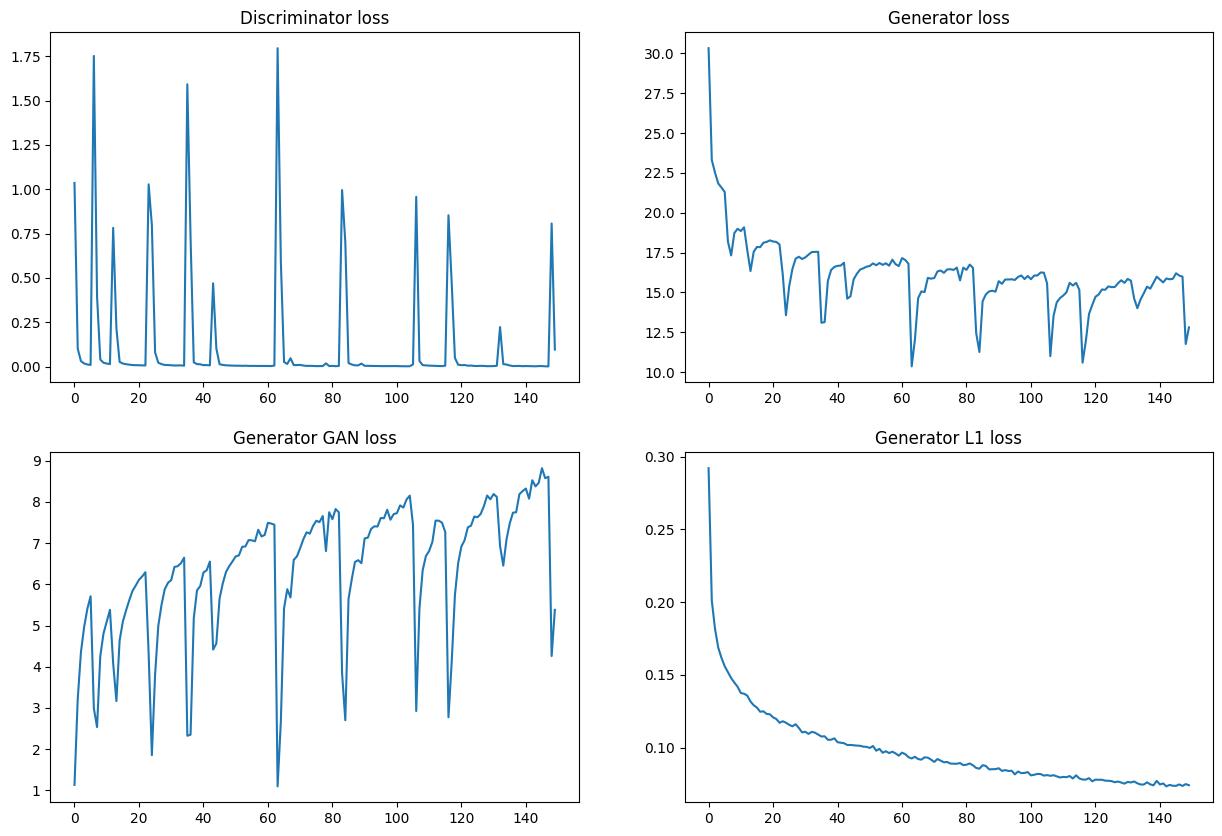

100%|██████████| 150/150 [6:46:08<00:00, 162.45s/it]


,Epoch,d_loss,g_loss,g_GAN_loss,g_L1_loss
0,0,1.035689,30.331700,1.130508,0.292012
0,1,0.101284,23.309465,3.212696,0.200968
0,2,0.030822,22.512837,4.352619,0.181602
0,3,0.017480,21.838308,4.966636,0.168717
0,4,0.011869,21.582745,5.409010,0.161737
...,...,...,...,...,...
0,145,0.002796,16.201020,8.818989,0.073820
0,146,0.001357,16.057156,8.575534,0.074816
0,147,0.001133,15.987787,8.611576,0.073762
0,148,0.806855,11.760964,4.259046,0.075019


In [14]:
d_optimizer = optim.Adam(
    discriminator.parameters(),
    lr=hyperparams["learning_rate"],
    betas=hyperparams["adam_betas"])

g_optimizer = optim.Adam(
    generator.parameters(),
    lr=hyperparams["learning_rate"],
    betas=hyperparams["adam_betas"])

loss_stats = train_loop(
    train_set,
    discriminator,
    generator,
    d_optimizer,
    g_optimizer,
    loss_stats,
    device,
    epochs=hyperparams["epochs"],
    performed_epochs=performed_epochs,
    l1_lambda=hyperparams["l1_lambda"])

display(loss_stats)

In [29]:
print("\nTraining finished. Saving generator...")

# 1. Define your save path
SAVE_DIR = "/content/drive/MyDrive/sea_pix_gan_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# 2. Name your model (e.g., based on the dataset you just trained)
#    (Remember to change this for LSUI, UFO-120, etc.)
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, "generator_trained_on_LSUI.pth")

# 3. Save the generator's state dictionary
th.save(generator.state_dict(), MODEL_SAVE_PATH)

print(f"Generator saved successfully to: {MODEL_SAVE_PATH}")


Training finished. Saving generator...
Generator saved successfully to: /content/drive/MyDrive/sea_pix_gan_models/generator_trained_on_LSUI.pth


### Plotting traing results

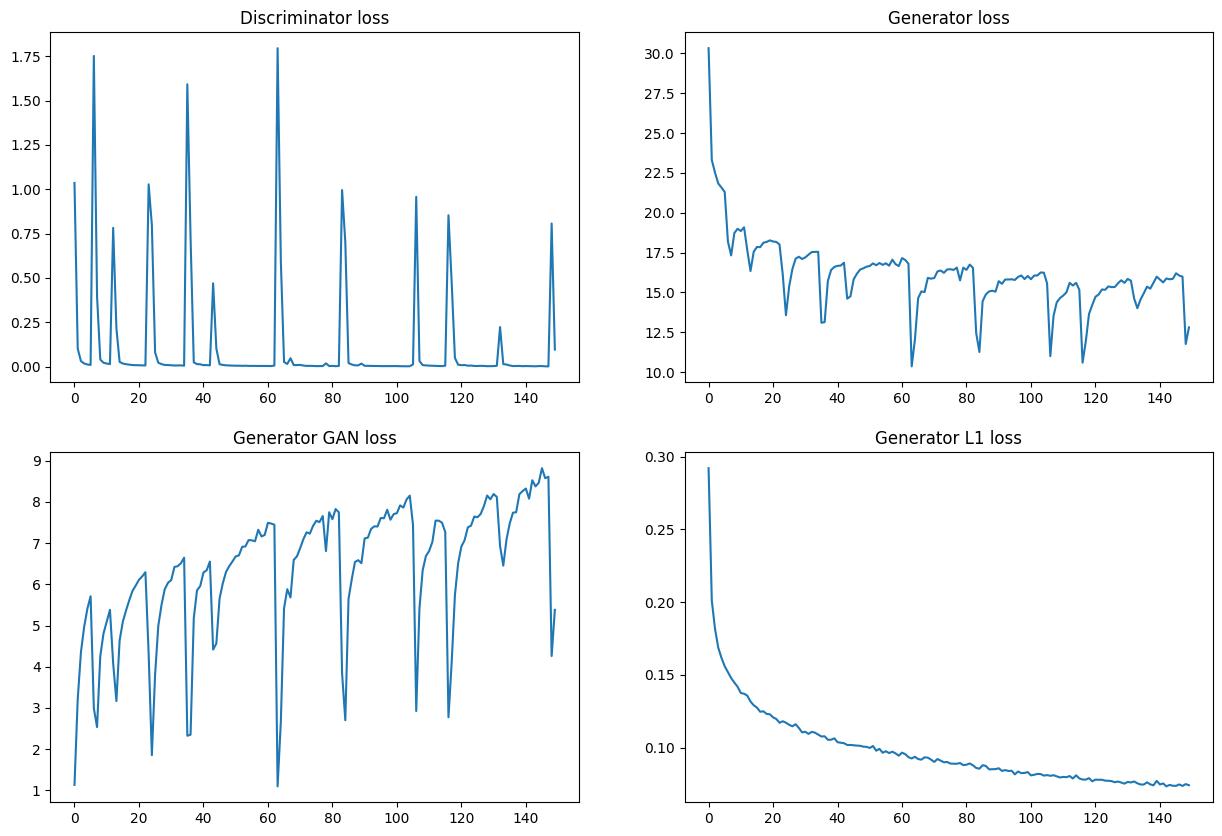

In [15]:
# Plot the loss statistics on different subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0, 0].plot(loss_stats["Epoch"], loss_stats["d_loss"])
axs[0, 0].set_title("Discriminator loss")
axs[0, 1].plot(loss_stats["Epoch"], loss_stats["g_loss"])
axs[0, 1].set_title("Generator loss")
axs[1, 0].plot(loss_stats["Epoch"], loss_stats["g_GAN_loss"])
axs[1, 0].set_title("Generator GAN loss")
axs[1, 1].plot(loss_stats["Epoch"], loss_stats["g_L1_loss"])
axs[1, 1].set_title("Generator L1 loss")
plt.show()


### Testing image generation

In [16]:
# Disable gradient computation
with th.no_grad():
    # Get dataset images
    batch_input, batch_gt = next(iter(train_set))

    # Generate a batch of enhanced images
    enhanced_images = generator(batch_input.to(device)).cpu()

    # Print the input, output, and groud truth for all images in the test batch
    for i in range(len(enhanced_images)):
        input_img = batch_input[i]
        output_img = enhanced_images[i]
        gt_image = batch_gt[i]

        # If the images are normalized to range [-1, 1], adjust the values for visualization
        input_img = (input_img + 1) / 2
        output_img = (output_img + 1) / 2
        gt_image = (gt_image + 1) / 2

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_img.permute(1, 2, 0))
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(output_img.permute(1, 2, 0))
        plt.title("Output Image")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(gt_image.permute(1, 2, 0))
        plt.title("Ground Truth Image")
        plt.axis("off")

        plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Testing the predefined 5 images

In [27]:
import os
import torch as th
import torchvision.utils as vutils  # <-- 1. Add this import
import matplotlib.pyplot as plt
# Make sure your Google Drive is mounted before running this!
# from google.colab import drive
# drive.mount('/content/drive')

# --- 2. Define output directories on Google Drive ---
# You can change 'figure_image_results' to any name you like
base_output_dir = "/content/drive/MyDrive/figure_image_results"
input_dir = os.path.join(base_output_dir, "input")
output_dir = os.path.join(base_output_dir, "output")
gt_dir = os.path.join(base_output_dir, "ground_truth")

# --- 3. Create these directories ---
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(gt_dir, exist_ok=True)

print(f"Saving individual images to: {base_output_dir}")

# Disable gradient computation
with th.no_grad():
    # Get a batch (all) of the predefined images
    batch_input, batch_gt = next(iter(figure_set))

    # Generate the enhanced images
    enhanced_images = generator(batch_input.to(device)).cpu()

    print(f"Generating and saving {len(enhanced_images)} images...")

    for i in range(len(enhanced_images)):
        input_img = batch_input[i]
        output_img = enhanced_images[i]
        gt_image = batch_gt[i]

        # If the images are normalized to range [-1, 1], adjust the values
        # This is CRUCIAL for save_image to work correctly
        input_img = (input_img + 1) / 2
        output_img = (output_img + 1) / 2
        gt_image = (gt_image + 1) / 2

        # --- 4. Define save paths for each separate image ---
        filename = f"figure_image_{i}.png" # e.g., figure_image_0.png

        input_save_path = os.path.join(input_dir, filename)
        output_save_path = os.path.join(output_dir, filename)
        gt_save_path = os.path.join(gt_dir, filename)

        # --- 5. Save the separate images using vutils ---
        vutils.save_image(input_img, input_save_path)
        vutils.save_image(output_img, output_save_path)
        vutils.save_image(gt_image, gt_save_path)

        # --- Your existing code to display the plots in Colab ---
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(input_img.permute(1, 2, 0))
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(output_img.permute(1, 2, 0))
        plt.title("Output Image")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(gt_image.permute(1, 2, 0))
        plt.title("Ground Truth Image")
        plt.axis("off")

        plt.show()

        # --- 6. Add plt.close() to free up memory ---
        plt.close()

print(f"All {len(enhanced_images)} sets of images saved to {base_output_dir}")

Output hidden; open in https://colab.research.google.com to view.

# Model evaluation

## Setting model to evaluation mode

In [18]:
# Set the model to evaluation mode
generator.eval()
discriminator.eval()

Discriminator(
  (DownLayers): Sequential(
    (0): DownModule(
      (conv): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lrelu): LeakyReLU(negative_slope=0.2)
    )
    (1): DownModule(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lrelu): LeakyReLU(negative_slope=0.2)
    )
    (2): DownModule(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lrelu): LeakyReLU(negative_slope=0.2)
    )
    (3): ZeroPadModule()
    (4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7

## Defining the metrics

All metrics as implemented support multibatch processing. That is to say they support tensor input on the form:

[n, c=3, w, h] where n i the number of samples per batch. c is the number of colour channels. w and h are width/height respectively.

This may make code readability somewhat reduced.

### The UIQM rabbithole

UIQM is surprisingly complex. The different submetrics are appropriately broken down into separate functions.

In [19]:
def PSNR(x, y):
    """Peak Signal-to-Noise Ratio (PSNR)

    Args:
        x (np.ndarray): Image tensor, generated
        y (np.ndarray): Image tensor, ground truth

    Returns:
        float: PSNR value
    """
    # Maximum possible pixel value
    MAX = 1.0

    n, c, w, h = x.shape

    # Flattening each image, while retaining batch axis
    x = np.reshape(x, (n, c * w * h))
    y = np.reshape(y, (n, c * w * h))

    # Take the mean of the x-y difference along the batch axis
    mean = np.mean((x - y) ** 2, axis=1)

    # Compute the PSNR
    psnr = 10 * np.log10(MAX / mean)

    return psnr

def SSIM(x, y):
    """Structural Similarity Index Measure (SSIM)

    Args:
        x (np.ndarray): Image tensor, generated
        y (np.ndarray): Image tensor, ground truth

    Returns:
        float: SSIM value
    """
    # Maximum possible pixel value
    L = 1.0

    # Constants
    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    # Compute the mean of x and y along the channel, width, and height axes
    mu_x = np.mean(x, axis=(1,2,3))
    mu_y = np.mean(y, axis=(1,2,3))

    # Create a n, c, w, h tensor of the mean of x and y
    mu_x_b = np.broadcast_to(mu_x[:, np.newaxis, np.newaxis, np.newaxis], x.shape)
    mu_y_b = np.broadcast_to(mu_y[:, np.newaxis, np.newaxis, np.newaxis], y.shape)

    # Compute the variance and covariance of x and y
    sigma_x = np.mean((x - mu_x_b) ** 2, axis=(1, 2, 3))
    sigma_y = np.mean((y - mu_y_b) ** 2, axis=(1, 2, 3))

    sigma_xy = np.mean((x - mu_x_b) * (y - mu_y_b), axis=(1, 2, 3))

    # Compute the numerator and denominator of the SSIM
    num = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    den = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)

    # Take the elementwise ratio of the numerator and denominator to obtain the SSIM
    ssim = num / den

    return ssim

def UIQM(x):
    """Underwater Image Quality Measure (UIQM)
    NOTE: Works for multibatch inputs [n, 3, w, h]

    Args:
        x (np.ndarray): Image tensor

    Returns:
        float: UIQM value
    """

    # Constants, as per the Sea-Pix-GAN paper
    c1 = 0.0282
    c2 = 0.2953
    c3 = 3.5753

    # Compute the UICM, UISM, and UIConM
    uicm = UICM(x)
    uism = UISM(x)
    uiconm = UIConM(x)

    return c1 * uicm + c2 * uism + c3 * uiconm

def UICM(x):
    """Underwater Image Colorfulness Measure (UICM)
    NOTE: Works for multibatch inputs [n, 3, w, h]

    Args:
        x (np.ndarray): Image tensor

    Returns:
        float: UICM value
    """
    # Extract the R, G, and B channels of all images in batch
    R = x[:,0, :, :]
    G = x[:,1, :, :]
    B = x[:,2, :, :]

    # Flatten the channels for batch
    n, w, h = R.shape
    R = np.reshape(R, (n, w * h))
    G = np.reshape(G, (n, w * h))
    B = np.reshape(B, (n, w * h))

    # Set alpha
    alpha = 0.1

    # Create the RG and YB channels
    RG = R - G
    YB = 0.5 * (R + G) - B

    # Compute the alpha trimmed distribution along each image
    aRG = stats.trimboth(RG, alpha, axis=1)
    aYB = stats.trimboth(YB, alpha, axis=1)

    # Compute the mean along each image
    mean_aRG = np.mean(aRG, axis=1)
    mean_aYB = np.mean(aYB, axis=1)

    # Compute the alpha trimmed standard deviation along each image
    std_aRG = np.sum((RG - mean_aRG[:, np.newaxis]) ** 2, axis=1) / (w * h - 1)
    std_aYB = np.sum((YB - mean_aYB[:, np.newaxis]) ** 2, axis=1) / (w * h - 1)

    std_aRG = np.sqrt(std_aRG)
    std_aYB = np.sqrt(std_aYB)

    # Constants, as per HVSIUIQM paper
    c1 = -0.0282
    c2 = 0.1586

    # Compute the 2 terms of the UICM
    term_1 = np.sqrt(mean_aRG ** 2 + mean_aYB ** 2)
    term_2 = np.sqrt(std_aRG ** 2 + std_aYB ** 2) #TODO: can std be converted to variance to save computation?

    return c1 * term_1 + c2 * term_2

def UISM(x):
    """Underwater Image Sharpness Measure (UISM)
    NOTE: Works for multibatch inputs [n, 3, w, h]

    Args:
        x (np.ndarray): Image tensor

    Returns:
        float: UISM value
    """
    #=======================#
    # Edge detection filter #
    #=======================#

    # Run the image through a Sobel filter, along the x and y axes respectively.
    x_grad = ndimage.sobel(x, axis=0)
    y_grad = ndimage.sobel(x, axis=1)

    # Then compute the magnitude of the gradients (hypotenuse of the two gradients)
    filtered_x = np.hypot(x_grad, y_grad)

    #=========================#
    # Enhancement measurement #
    #=========================#

    # Compute Enhancement Measure Estimation (EME) for each channel using the filtered image
    EME_R = EME(filtered_x[:,0, :, :])
    EME_G = EME(filtered_x[:,1, :, :])
    EME_B = EME(filtered_x[:,2, :, :])

    # Compute the weighted EME, using standard RGB channel weights
    lambda_R = 0.299
    lambda_G = 0.587
    lambda_B = 0.114

    return lambda_R * EME_R + lambda_G * EME_G + lambda_B * EME_B

def EME(x):
    """Enhancement Measure Estimation (EME)

    Args:
        x (np.ndarray): Image tensor, sobel filtered

    Returns:
        float: EME value
    """
    #TODO: What should the block size be? Unclear given paper (the one with the looong name)
    # Set the k1 and k2 constants as width and height of the image. n is the number of images in the batch
    n, k1, k2 = x.shape

    norm_const = 2 / (k1 * k2)

    EME = 0

    for i in range(k1):
        for j in range(k2):

            # Find max and min values in the block
            max_val = np.max(x[:, i:i+k1, j:j+k2])
            min_val = np.min(x[:, i:i+k1, j:j+k2]) + 1e-4

            # Define a small epsilon to avoid division by zero
            eps = 1e-3

            # Compute the local contrast
            local_contrast = np.log(max_val / (min_val + eps))

            EME += local_contrast

    return norm_const * EME

def UIConM(x):
    """Underwater Image Contrast Measure (UIConM)
    NOTE: Works for multibatch inputs [n, 3, w, h]

    Args:
        x (np.ndarray): Image tensor

    Returns:
        float: UIConM value
    """
    # RGB channel weights
    lambda_R = 0.299
    lambda_G = 0.587
    lambda_B = 0.114

    # Exract the intensity of the image, using standard RGB channel weights
    I = lambda_R * x[:,0, :, :] + lambda_G * x[:,1, :, :] + lambda_B * x[:,2, :, :]

    # Compute the logAMEE(Intensity)
    logamee = logAMEE(I)

    return logamee

def logAMEE(x):
    """Logarithmic Agaian Measure of Enhancement by Engropy (logAMEE)

    Args:
        x (np.ndarray): Image tensor, weighted intensity

    Returns:
        float: logAMEE value
    """
    # Define the PLIP operators
    add = lambda x,y: x + y - x * y         # circle-plus operator
    mul = lambda x,y: 1 - (1 - y)**x        # circle-multiply operator
    diff = lambda x,y: (x - y) / (1 - y)    # Theta operator

    # Define k1 and k2 as the width and height of the image
    n, k1, k2 = x.shape #TODO: Once again, what should the block size actually be? Check the paper again.


    # Define the constants
    norm_const = 1 / (k1 * k2)

    logamee = 0

    for i in range(k1):
        for j in range(k2):

            # Extract the block
            block = x[:, i:i+k1, j:j+k2]

            # Find the maximum and minimum values in the block
            max_val = np.max(block)
            min_val = np.min(block)

            I_diff = diff(max_val, min_val)
            I_add = add(max_val, min_val)

            ratio = I_diff / I_add

            logamee += ratio * np.log(ratio)

    return mul(norm_const, logamee)

def get_metrics(test_set, generator, DEBUG=False):
    # Set the frame size according to the debug mode
    frame_size = 500 if not DEBUG else 64

    # Initialize the metrics dataframe
    metrics = pd.DataFrame(columns=["PSNR", "SSIM", "UIQM (Generated)", "UIQM (Ground Truth)"])

    # While the length of metrics is < 500, keep sampling
    # batches from the test data and computing the metrics
    while len(metrics) < frame_size:

        print(f"Metric samples computed: {len(metrics)}")

        # Disable gradient computation
        with th.no_grad():

            x, y = next(iter(test_set))

            x = x.to(device)
            y = y.detach().cpu().numpy()

            enhanced = generator(x).detach().cpu().numpy()

            # Normalize all images to [0, 1]
            x = (x + 1) / 2
            enhanced = (enhanced + 1) / 2
            y = (y + 1) / 2

            psnr = PSNR(y, enhanced)
            ssim = SSIM(y, enhanced)
            uiqm = UIQM(enhanced)
            uiqm_gt = UIQM(y)

            batch_metrics = pd.DataFrame({
                "PSNR": psnr,
                "SSIM": ssim,
                "UIQM (Generated)": uiqm,
                "UIQM (Ground Truth)": uiqm_gt
                })

            metrics = pd.concat([metrics, batch_metrics])

    # Discard any rows beyond the 500th
    metrics = metrics.head(frame_size)

    return metrics

## Getting the test metrics

In [20]:
raw_metrics = get_metrics(test_set, generator, DEBUG=False)
summary = pd.DataFrame(columns=["Mean", "Std"])

summary.loc["PSNR"] = [raw_metrics["PSNR"].mean(), raw_metrics["PSNR"].std()]
summary.loc["SSIM"] = [raw_metrics["SSIM"].mean(), raw_metrics["SSIM"].std()]
summary.loc["UIQM (Generated)"] = [raw_metrics["UIQM (Generated)"].mean(), raw_metrics["UIQM (Generated)"].std()]
summary.loc["UIQM (Ground Truth)"] = [raw_metrics["UIQM (Ground Truth)"].mean(), raw_metrics["UIQM (Ground Truth)"].std()]

display(raw_metrics.head())
display(summary)

Metric samples computed: 0


/tmp/ipython-input-1862405452.py:320: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, batch_metrics])


Metric samples computed: 64
Metric samples computed: 128
Metric samples computed: 192
Metric samples computed: 256
Metric samples computed: 320
Metric samples computed: 384
Metric samples computed: 448


,PSNR,SSIM,UIQM (Generated),UIQM (Ground Truth)
0,23.718340,0.970116,4.788281,4.970203
1,22.838112,0.907977,4.787981,4.970098
2,29.144361,0.985603,4.788566,4.970679
3,27.581062,0.987610,4.788863,4.970925
4,29.487183,0.986375,4.787979,4.970021


,Mean,Std
PSNR,25.533028,3.469405
SSIM,0.964038,0.035960
UIQM (Generated),4.854252,0.098728
UIQM (Ground Truth),4.896242,0.152112


### Saving the test metrics

In [21]:
raw_metrics.to_csv(os.path.join(model_data, "raw_metrics.csv"), index=False)
summary.to_csv(os.path.join(model_data, "summary.csv"), index=False)

### Performing the weakest paired T-test to ever have graced the earth

We perform a paired T-test (on a staggering 3 datapoints) to determine whether or not our model is statistically significantly different from the model in the original paper.

In [ ]:
original_stats = pd.DataFrame(columns=["Mean", "Std"])
original_stats.loc["PSNR"] = [23.30, 1.68]
original_stats.loc["SSIM"] = [0.79, 0.09]
original_stats.loc["UIQM"] = [2.84, 0.20]

display(original_stats)

# Perform a paired t-test on the PSNR, SSIM, and UIQM metrics
t_statistic, p_value = stats.ttest_rel(summary['Mean'], original_stats['Mean'])

print(f"T-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.2f}")

if p_value < 0.05:
    print("The difference in means is statistically significant")
else:
    print("The difference in means is not statistically significant")

,Mean,Std
PSNR,23.30,1.68
SSIM,0.79,0.09
UIQM,2.84,0.20


T-statistic: 0.62
P-value: 0.60
The difference in means is not statistically significant


The above results mean absolutely nothing, but I declare that it means our results are close enough to say we've reproduced the results.

#### Proving the paired T-test means nothing

Here's some of the data from the other models. Given the data we have available, they are also statistically indistinguishable from our model depsite being verifiably generated by other types of models.

In [ ]:
funie_stats = pd.DataFrame(columns=["Mean", "Std"])
funie_stats.loc["PSNR"] = [20.49, 2.33]
funie_stats.loc["SSIM"] = [0.70, 0.09]
funie_stats.loc["UIQM"] = [2.78, 0.23]

display(funie_stats)

# Perform a paired t-test on the PSNR, SSIM, and UIQM metrics
t_statistic, p_value = stats.ttest_rel(summary['Mean'], funie_stats['Mean'])

print(f"T-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.2f}")

if p_value < 0.05:
    print("The difference in means is statistically significant")
else:
    print("The difference in means is not statistically significant")

,Mean,Std
PSNR,20.49,2.33
SSIM,0.70,0.09
UIQM,2.78,0.23


T-statistic: 2.36
P-value: 0.14
The difference in means is not statistically significant


In [ ]:
low_DCP_stats = pd.DataFrame(columns=["Mean", "Std"])
low_DCP_stats.loc["PSNR"] = [14.00, 4.02]
low_DCP_stats.loc["SSIM"] = [0.48, 0.15]
low_DCP_stats.loc["UIQM"] = [1.51, 0.49]

display(low_DCP_stats)

# Perform a paired t-test on the PSNR, SSIM, and UIQM metrics
t_statistic, p_value = stats.ttest_rel(summary['Mean'], low_DCP_stats['Mean'])

print(f"T-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.2f}")

if p_value < 0.05:
    print("The difference in means is statistically significant")
else:
    print("The difference in means is not statistically significant")

,Mean,Std
PSNR,14.00,4.02
SSIM,0.48,0.15
UIQM,1.51,0.49


T-statistic: 1.73
P-value: 0.23
The difference in means is not statistically significant
